### XG-boost for Cheminformatics
conda install -c conda-forge py-xgboost
Note that py-xgboost-gpu is not available on Windows

https://xgboost.readthedocs.io/en/stable/install.html

Example usage on Kagle:

https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn

Also needed:

conda install graphviz python-graphviz


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle


from scipy.stats import uniform, randint

from sklearn.metrics import auc, accuracy_score, balanced_accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
from catboost import CatBoostClassifier


# import graphviz

In [12]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [13]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [14]:
# Load dataframe from CSV.
data = pd.read_csv(
    'https://raw.githubusercontent.com/cptlab/ASCEPT_2023_comptox_workshop/main/W109_Machine_learning_QSAR_for_toxicity_prediction/data/smiles_cas_N6512_corrected.smi',
    names=['SMILES', 'CAS', 'Ames'],
    delimiter='\t'
)

data = data.drop('CAS', axis=1)

### Datamol & Molfeat

A little demo on using datamol to generate RDKit mol objects and then molfeat to featurise them (leveraging multi-threading)

In [19]:
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer

calc = FPCalculator("ecfp")
transformer = MoleculeTransformer(featurizer=calc, n_jobs=-1)

data.SMILES = data.SMILES.apply(dm.to_mol)

data.SMILES = transformer.transform(data.SMILES)

data.rename(columns={'SMILES': 'MFP'}, inplace=True)  # In-place is not recommended, will soon be deprecated.

data.head(2)

AttributeError: 'DataFrame' object has no attribute 'SMILES'

### Basic XG-Boost model

If you want to make a confusion matrix look nice, simply import and use the ConfusionMatrixDisplay from SKLearn - Very easy and it's much nicer :)

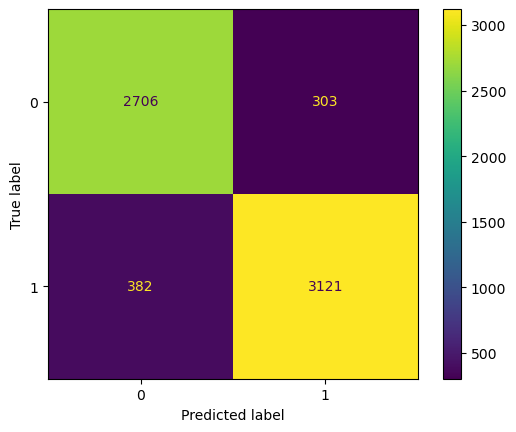

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create XG-boost model

X = data.MFP.apply(pd.Series)
y = data.Ames

model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model.fit(X, y)

y_pred = model.predict(X)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()

### Using Stratified K-fold Cross Validation and optimising via Optuna

You can run this again if you like, but it takes about 1.5 hours on a Ryzen 5 5600x and uses 100% of all cores for that duration.

**Notably, this optimisation consideres DART - https://arxiv.org/abs/1505.01866**

Think of it like dropout but for XGBoost

In [ ]:
import optuna

def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb_model = xgb.XGBClassifier(**param)

    score = cross_val_score(xgb_model, X, y, n_jobs=-1, cv=5, scoring="balanced_accuracy").mean()
    return score

study = optuna.create_study(
    direction="maximize",
    study_name="xgboost_parameter_opt",
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

study.optimize(objective, n_trials=100)

### Instead, I have hosted the best params online on my Honours GitHub repository

This downloads a pickleised dictionary of the best XGBoost hyperparameters Optuna found when I ran it with 100 trials and a MedianPruner

This is bad practice to download pickle files from the internet as they can execute arbitrary code, hence obvious malware concerns, etc. **As such, it's good practice to convert python objects to text or a df, and then convert them to a dict after downloading. This wasn't worth it for a small private demo, but it's worth considering if you're concerned with good practice for writing Python**

In [17]:
import pickle, requests

best_params_url = 'https://github.com/leftwinglow/Honours/raw/main/XGBoost_Testing/best_params.pkl'
response = requests.get(best_params_url)
best_params = pickle.loads(response.content)

print(best_params)

{'booster': 'dart', 'lambda': 7.879038206041689e-08, 'alpha': 0.08788830100764765, 'subsample': 0.6695131388230572, 'colsample_bytree': 0.6096458101072316, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.09575983680410466, 'gamma': 5.459056462587517e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006518338877838275, 'skip_drop': 9.936661012829011e-06}


### Now, let's run 5-fold stratified cross-validation and see which model is best

* XGBoost - No Optuna optimisation
* XGBoost - Optuna-optimised
* CatBoost - Unoptimised

I could not be bothered to write another Optuna optimisation script for CatBoost

This code would be much simpler if we could ascribe a human-readable name to each model via a dictionary (the name would be the value). Unfortunately this is not possible as the CatBoostClassifier is a non-hashable object. Instead we just make sure models and model_names have the same len() and have the same order. To ensure the column names are correct, we use enumerate to get the index of the current model in *models*, then use this to access the corresponding human readable name in *model_names*.

In [18]:
from tqdm import tqdm

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Can't use a dictionary for the models as the keys are not hashable - Thanks CatBoost smh
models = [xgb.XGBClassifier(random_state=42), xgb.XGBClassifier(**best_params, random_state=42), CatBoostClassifier(iterations=1000, task_type="GPU", devices='0:1', logging_level='Silent', random_state=42)]

model_names = ['unoptimised_xgb', 'optimised_xgb', 'catboost']

scores_df = pd.DataFrame()

for idx, model in enumerate(models):
    scores = []
    for train_index, test_index in tqdm(kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Correct indexing using iloc
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Correct indexing using iloc

        model = model
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        scores.append(balanced_accuracy_score(y_test, y_pred))

    scores_df[str(model_names[idx])] = scores

5it [00:07,  1.49s/it]
5it [11:03, 132.80s/it]
5it [02:19, 27.97s/it]


Some simple dataframe operations
* Compute the mean of each model
* Append the mean to the df
* Rename the index of the mean column

In [41]:
scores_df.loc[len(scores_df)] = scores_df.mean()
scores_df = scores_df.rename(index={5: "mean"})
scores_df

,unoptimised_xgb,optimised_xgb,catboost
0,0.803093,0.806054,0.805350
1,0.762611,0.773282,0.763325
2,0.807243,0.799751,0.791811
3,0.796312,0.796163,0.789070
4,0.800427,0.796740,0.792702
mean,0.793937,0.794398,0.788451


Plot the above df as a matplotlib boxplot

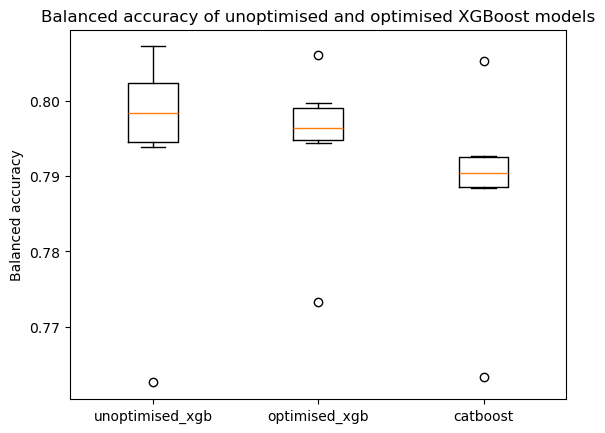

In [43]:
plt.boxplot([scores_df.unoptimised_xgb, scores_df.optimised_xgb, scores_df.catboost], labels=[*model_names])
plt.title('Balanced accuracy of unoptimised and optimised XGBoost models')
plt.ylabel('Balanced accuracy')
plt.show()

Save the model and best params

In [125]:
# Save model
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save params
with open("best_params.pkl", "wb") as f:
    pickle.dump(study.best_params, f)

# I did not touch anything below - It's very interesting though, give it a read

### Plotting feature importance using graphviz
Since fingerprints don't give away their meaning too easily,

it makes sense to use mordred descriptors for feature importance analysis.

In [12]:
import pandas as pd
from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]

    # pandas df
    df = calc.pandas(mols)
    return df

In [ ]:
mordred_descriptors = All_Mordred_descriptors(data['SMILES'])

In [30]:
X = mordred_descriptors.astype(float)
y = data['Ames'].astype(int)

In [22]:
# Drop first two descriptors because they where all NaN's.
nan_columns = X.columns[X.isnull().any()]
print(nan_columns)
X = mordred_descriptors.iloc[:, 2:]
# Now there are no NaN's left.

d:\Users\slade\Anaconda3\envs\datamol\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


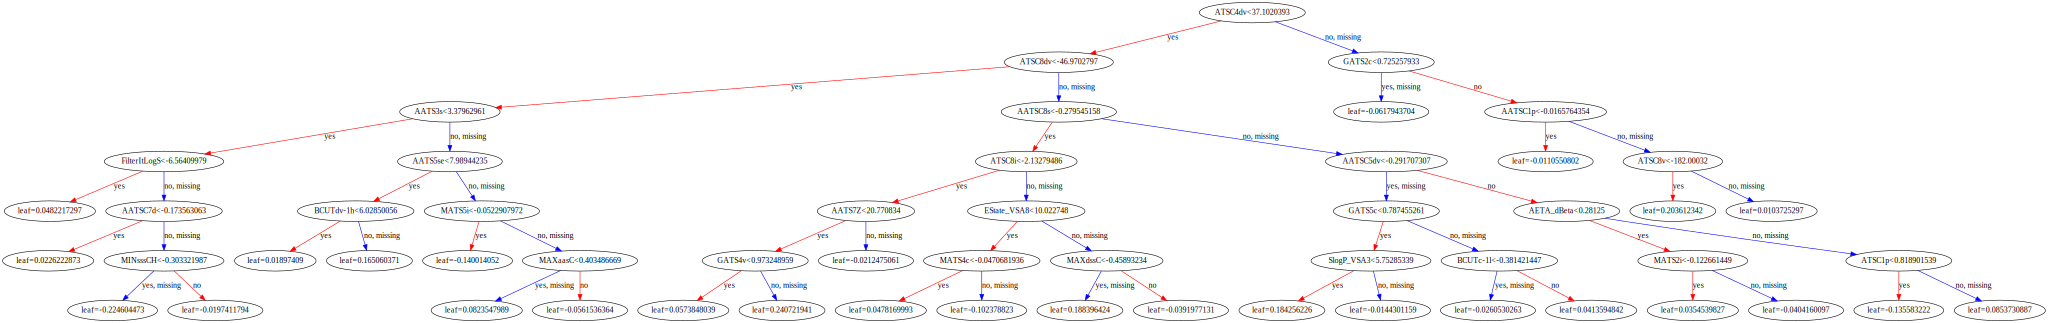

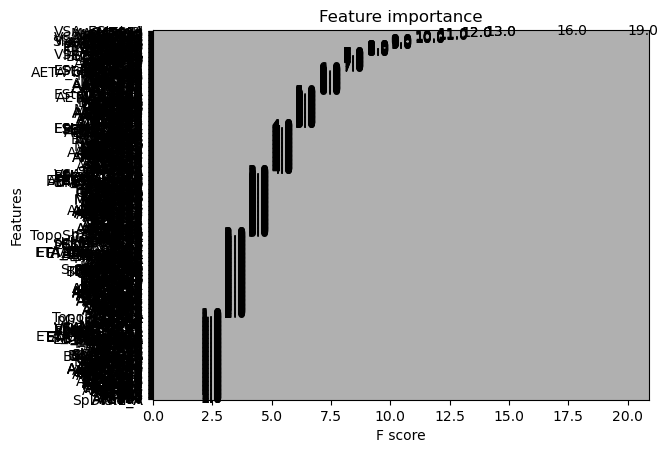

In [53]:
# requires graphviz and python-graphviz conda packages
import graphviz


model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

xgb.plot_importance(model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(model, num_trees=model.best_iteration)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

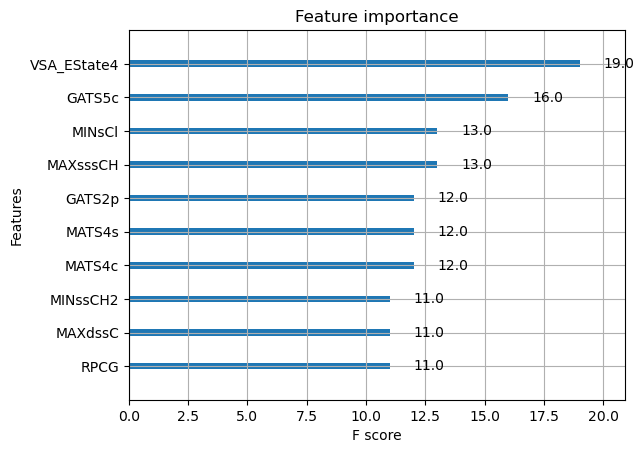

In [54]:
xgb.plot_importance(model, max_num_features=10)  # Plot top 10 features


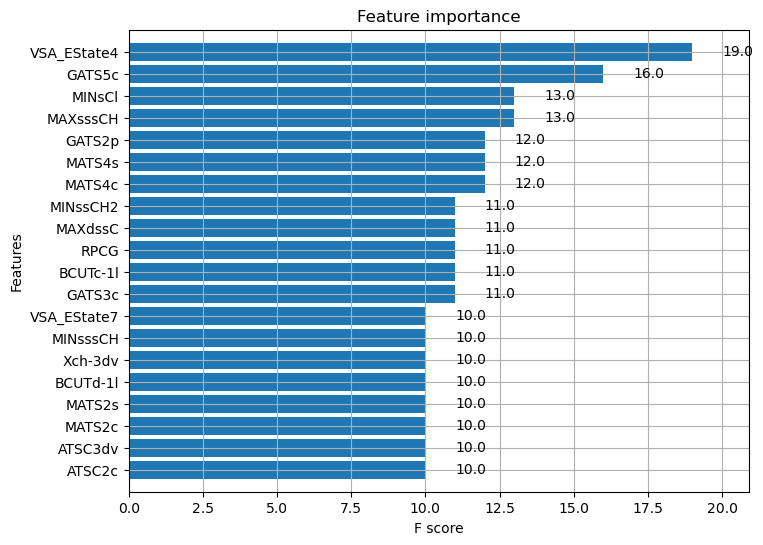

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
xgb.plot_importance(model, ax=ax, max_num_features=20, height=0.8, importance_type='weight')
plt.show()


### Recursive Feature Elimination (RFE)

Following the feature importance plots
We can now reduce the size of the list of descriptors to a managable level for RFE
You can't easily do RFE on 1826 descriptors as it builds a new model for each.

In [67]:
# Note that F score above corresponds to "weight" here.
importance = model.get_booster().get_score(importance_type='weight')  # Can change importance_type
top_features = sorted(importance, key=importance.get, reverse=True)[:50]  # Get top 50 features
print(top_features)


['GATS5c', 'AATS4se', 'ATSC1c', 'BCUTi-1h', 'MATS4c', 'ATSC2d', 'BCUTd-1l', 'BCUTc-1l', 'MAXaasC', 'ATSC1i', 'MATS2c', 'AATSC0d', 'MAXdssC', 'VSA_EState4', 'MAXssCH2', 'MINsOH', 'MAXsssCH', 'MINsCl', 'SlogP_VSA10', 'Xch-3dv']


In [58]:
# Select columns corresponding to top features
X_reduced = X[top_features]

In [63]:
# If it takes 27 seconds to make one model, this will take
# about 13.7 hours to run with 1826 mrodred descriptors.
# So I have selected a smaller number to sart with from
# the feature importance above (top 50).
from sklearn.feature_selection import RFE
import xgboost as xgb

# Initialize XGBoost model
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Initialize RFE with XGBoost model
rfe = RFE(estimator=model, n_features_to_select=20, step=1)

# Fit RFE to the training data
rfe.fit(X_reduced, y)

# Get selected features
selected_features = X_reduced.columns[rfe.support_]

# Print selected features
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['VSA_EState4', 'GATS5c', 'MAXsssCH', 'MINsCl', 'MATS4c', 'BCUTc-1l',
       'MAXdssC', 'MATS2c', 'BCUTd-1l', 'Xch-3dv', 'ATSC1c', 'MAXssCH2',
       'MAXaasC', 'SlogP_VSA10', 'ATSC2d', 'ATSC1i', 'AATSC0d', 'BCUTi-1h',
       'MINsOH', 'AATS4se'],
      dtype='object')


In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.4, random_state=0)


In [80]:
# Train XGBoost model using selected features
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_accuracy)


[[ 906  270]
 [ 294 1135]]
Balanced Accuracy: 0.7823349423744306


d:\Users\slade\Anaconda3\envs\datamol\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


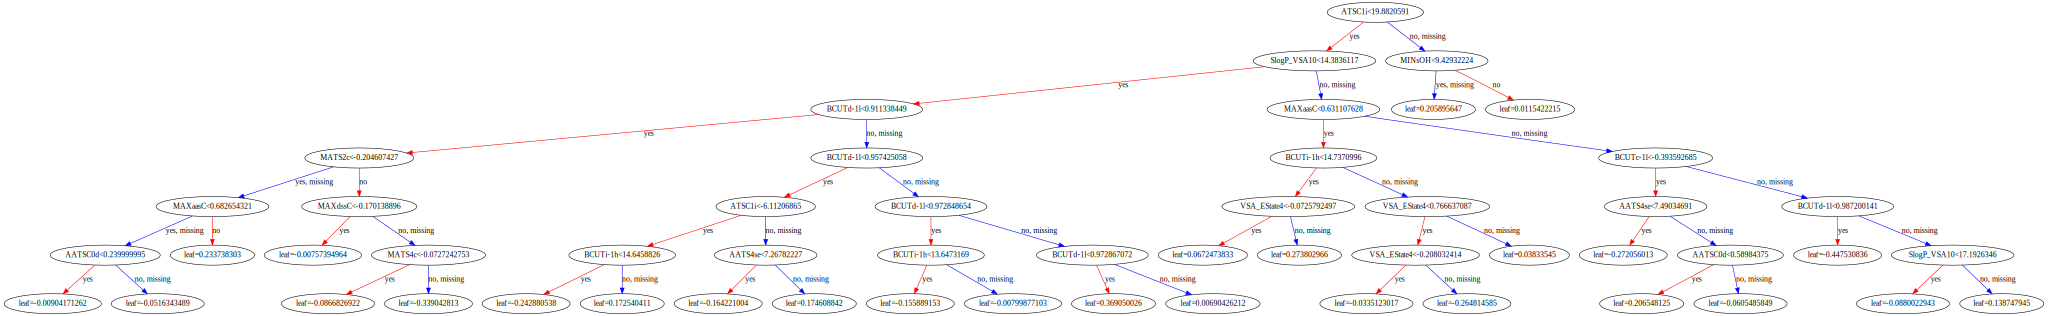

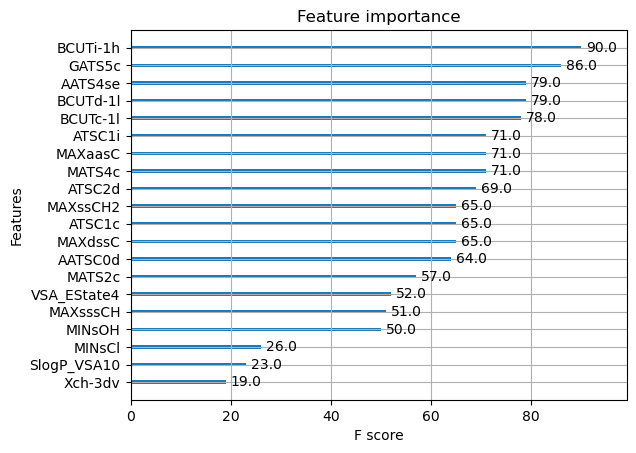

In [92]:
# There are several different eval_metrics that can be used to
# assess the performance of the model. Here I use aucpr.
# It measures the trade-off between precision and recall
# across different threshold values. said to be good for imbalanced data.
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="aucpr")

model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

xgb.plot_importance(model)

# converts the target tree to a graphviz instance
xgb.to_graphviz(model, num_trees=model.best_iteration)